## V5

In [113]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta

pd.set_option('display.float_format', lambda x: '%.5f' % x)

# Use 3 decimal places in output display
pd.set_option("display.precision", 3)


In [114]:
df_shops = pd.read_csv("shops.csv")
df_shops.describe()

,shop_id
count,60.00000
mean,29.50000
std,17.46425
min,0.00000
25%,14.75000
50%,29.50000
75%,44.25000
max,59.00000


In [115]:
# get valid shop id
def valid_shop_id(id):
    if id == 0:
        return 57
    if id == 1:
        return 58
#    if id == 23:
#        return 24
    if id == 11:
        return 10
    if id == 40:
        return 39 
    return id

def shop_type(shop):
    #types = ['ТК', 'ТЦ', 'ТРК', 'ТРЦ']
    p = re.compile(r"(Т[РКЦ]+)")
    r = p.search(shop)
    if r is not None: return r.group(1) 
    if 'нлайн' in shop: return 'Онлайн'
    if 'нтернет' in shop: return 'Онлайн'
    return 'Магазин'

# get city
def shop_city(shop):
    p = re.compile(r"^([а-яА-Я\.]*)")
    r = p.search(shop)
    if r is not None: return r.group(1) 
    return 'Unknown'

#df_shops['valid_id'] = df_shops['shop_id'] 

In [116]:
df_shops.drop([0,1], inplace=True)

In [117]:
df_shops['city'] = df_shops['shop_name'].apply(lambda x: shop_city(x))
df_shops['type'] = df_shops['shop_name'].apply(lambda x: shop_type(x))
df_shops['mega'] = df_shops['shop_name'].str.contains('мега', case=False).astype(int)

In [118]:
df_shops = df_shops.set_index('shop_id')
df_shops.tail()

,shop_name,city,type,mega
shop_id,,,,
55,Цифровой склад 1С-Онлайн,Цифровой,Онлайн,0
56,"Чехов ТРЦ ""Карнавал""",Чехов,ТРЦ,0
57,"Якутск Орджоникидзе, 56",Якутск,Магазин,0
58,"Якутск ТЦ ""Центральный""",Якутск,ТЦ,0
59,"Ярославль ТЦ ""Альтаир""",Ярославль,ТЦ,0


In [119]:
 df_shops.iloc[25]['type']

'ТЦ'

In [120]:
df_categories = pd.read_csv("item_categories.csv", index_col='item_category_id')
df_categories.describe()

,item_category_name
count,84
unique,84
top,Книги - Методические материалы 1С
freq,1


In [121]:
df_categories['category'] = df_categories['item_category_name'].str.split('[-(]', n=0).str[0].str.strip()
df_categories['digital'] = df_categories['item_category_name'].str.contains('цифра', case=False).astype(int)

In [122]:
df_categories.index.names = ['category_id']
df_categories.head()

,item_category_name,category,digital
category_id,,,
0,PC - Гарнитуры/Наушники,PC,0
1,Аксессуары - PS2,Аксессуары,0
2,Аксессуары - PS3,Аксессуары,0
3,Аксессуары - PS4,Аксессуары,0
4,Аксессуары - PSP,Аксессуары,0


In [123]:
df_items = pd.read_csv("items.csv", index_col='item_id')
df_items.describe()

,item_category_id
count,22170.00000
mean,46.29075
std,15.94149
min,0.00000
25%,37.00000
50%,40.00000
75%,58.00000
max,83.00000


In [124]:
df_items.head()

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40


In [125]:
df_test = pd.read_csv("test.csv")
df_test.describe()

,ID,shop_id,item_id
count,214200.00000,214200.00000,214200.00000
mean,107099.50000,31.64286,11019.39863
std,61834.35817,17.56193,6252.64459
min,0.00000,2.00000,30.00000
25%,53549.75000,16.00000,5381.50000
50%,107099.50000,34.50000,11203.00000
75%,160649.25000,47.00000,16071.50000
max,214199.00000,59.00000,22167.00000


In [126]:
federal_cities = ['Москва', 'СПб']
milioner_cities = ['Воронеж', 'Казань', 'Красноярск', 'Н.Новгород', 'Новосибирск', 'Омск', 'РостовНаДону', 'Самара', 'Уфа']
regional_caps = ['Адыгея', 'Калуга', 'Курск', 'Тюмень', 'Якутск', 'Ярославль', 'Вологда', 'Томск']
regional_cities = ['Балашиха', 'Волжский', 'Жуковский', 'Коломна', 'Сергиев', 'Сургут', 'Химки', 'Чехов', 'Мытищи']

shop_types = {}
shop_cities = {}
mega_shops = {}
categories = {}
digital_categories = {}
items = {}

def get_city_type(city):
    if city in federal_cities: return 'Federal' 
    if city in milioner_cities: return 'Milioner' 
    if city in regional_caps: return 'RegionalCenter' 
    if city in regional_cities: return 'Regional' 
    return 'Virtual'

def get_category(item_id):
    if item_id in items:
        category_id = items[item_id]
    else:
        category_id = df_items.loc[item_id]['item_category_id']
        items[item_id] = category_id
    
    if category_id not in categories:
        categories[category_id] = df_categories.loc[category_id]['item_category_name']
#        categories[category_id] = df_categories.loc[category_id]['category']
    return categories[category_id]


def get_category_digitality(item_id):
    if item_id in items:
        category_id = items[item_id]
    else:
        category_id = df_items.loc[item_id]['item_category_id']
        items[item_id] = category_id
    
    if category_id not in digital_categories:
        digital_categories[category_id] = df_categories.loc[category_id]['digital']
    return digital_categories[category_id]

def get_shop_type(shop_id):
    if shop_id not in shop_types:
        shop_types[shop_id] = df_shops.loc[shop_id]['type']
    return shop_types[shop_id]

def get_shop_megality(shop_id):
    if shop_id not in mega_shops:
        mega_shops[shop_id] = df_shops.loc[shop_id]['mega']
    return mega_shops[shop_id]

def get_shop_city(shop_id):
    if shop_id not in shop_cities:
        shop_cities[shop_id] = df_shops.loc[shop_id]['city']
    return shop_cities[shop_id]

In [127]:
df_sales = pd.read_csv("sales_train.csv")
df_sales.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849.00000,2935849.00000,2935849.00000,2935849.00000,2935849.00000
mean,14.56991,33.00173,10197.22706,890.85323,1.24264
std,9.42299,16.22697,6324.29735,1729.79963,2.61883
min,0.00000,0.00000,0.00000,-1.00000,-22.00000
25%,7.00000,22.00000,4476.00000,249.00000,1.00000
50%,14.00000,31.00000,9343.00000,399.00000,1.00000
75%,23.00000,47.00000,15684.00000,999.00000,1.00000
max,33.00000,59.00000,22169.00000,307980.00000,2169.00000


In [128]:
%%time
df_sales['shop_id'] = df_sales['shop_id'].apply(lambda x: valid_shop_id(x))
df_sales['revenue'] = df_sales['item_cnt_day'] * df_sales['item_price']
df_sales = df_sales.groupby(['date_block_num','shop_id','item_id'])[['item_cnt_day', 'revenue']].sum().reset_index()
df_sales.head()

CPU times: user 4.93 s, sys: 49.6 ms, total: 4.98 s
Wall time: 4.98 s


,date_block_num,shop_id,item_id,item_cnt_day,revenue
0,0,2,27,1.00000,2499.00000
1,0,2,33,1.00000,499.00000
2,0,2,317,1.00000,299.00000
3,0,2,438,1.00000,299.00000
4,0,2,471,2.00000,798.00000


In [129]:
#df_sales.loc[(df_sales['date_block_num']==0) & (df_sales['item_id'] == 2552) & (df_sales['shop_id'] == 25)]
df_shops.loc[59]

shop_name    Ярославль ТЦ "Альтаир"
city                      Ярославль
type                             ТЦ
mega                              0
Name: 59, dtype: object

In [130]:
%%time
df_sales['shop_type'] = df_sales['shop_id'].apply(lambda x: get_shop_type(x))

CPU times: user 1.02 s, sys: 3.04 ms, total: 1.02 s
Wall time: 1.02 s


In [131]:
%%time
df_sales['category'] = df_sales['item_id'].apply(lambda x: get_category(x))

CPU times: user 9.94 s, sys: 25.1 ms, total: 9.96 s
Wall time: 10.1 s


In [132]:
%%time
df_sales['city'] = df_sales['shop_id'].apply(lambda x: get_shop_city(x))

CPU times: user 1.02 s, sys: 3.11 ms, total: 1.02 s
Wall time: 1.02 s


In [133]:
#Clip
#df_sales['item_cnt_day'] = np.clip(df_sales['item_cnt_day'], 0, 20)

In [134]:
df_sales['month'] = df_sales['date_block_num']%12 + 1

In [135]:
df_sales.head()

,date_block_num,shop_id,item_id,item_cnt_day,revenue,shop_type,category,city,month
0,0,2,27,1.00000,2499.00000,ТЦ,Игры - PS3,Адыгея,1
1,0,2,33,1.00000,499.00000,ТЦ,Кино - Blu-Ray,Адыгея,1
2,0,2,317,1.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
3,0,2,438,1.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
4,0,2,471,2.00000,798.00000,ТЦ,Книги - Методические материалы 1С,Адыгея,1


## Cluster Analysis

- shops
- cities
- categories

### Cluster analysis for shops

In [136]:
df_sales_items = df_sales.groupby(['date_block_num','shop_id'])['item_cnt_day'].sum().reset_index()
df_sales_items['month'] = df_sales_items['date_block_num'] % 12 + 1
df_sales_items.head()

,date_block_num,shop_id,item_cnt_day,month
0,0,2,1146.00000,1
1,0,3,767.00000,1
2,0,4,2114.00000,1
3,0,6,3686.00000,1
4,0,7,2495.00000,1


In [137]:
# for clustrer analysis
df_cluster_sales = df_sales_items.groupby(['month','shop_id'])['item_cnt_day'].mean().to_frame(name='item_cnt_month').reset_index()
df_cluster_sales.head(10)

,month,shop_id,item_cnt_month
0,1,2,1007.66667
1,1,3,904.00000
2,1,4,1577.33333
3,1,5,1521.50000
4,1,6,3012.66667
5,1,7,2309.33333
6,1,8,1463.00000
7,1,10,782.33333
8,1,12,1592.33333
9,1,13,1069.00000


In [138]:
# for clustrer analysis
df_cluster_shops = df_cluster_sales.pivot_table(index=['shop_id'], columns=['month'], values=['item_cnt_month'], fill_value=0)
df_cluster_shops.reset_index(inplace=True)
df_cluster_shops.columns = [ ''.join((name, str(date))) for (name, date) in df_cluster_shops.columns.values]
df_cluster_shops.head()

,shop_id,item_cnt_month1,item_cnt_month2,item_cnt_month3,item_cnt_month4,item_cnt_month5,item_cnt_month6,item_cnt_month7,item_cnt_month8,item_cnt_month9,item_cnt_month10,item_cnt_month11,item_cnt_month12
0,2,1007.66667,768.66667,835.00000,744.33333,768.66667,864.33333,810.00000,924.33333,895.66667,822.33333,1027.00000,1621.50000
1,3,904.00000,803.00000,935.00000,690.66667,739.00000,761.33333,671.33333,819.33333,910.33333,737.00000,1016.50000,1204.50000
2,4,1577.33333,1434.66667,1428.00000,779.66667,1142.66667,1156.66667,1103.66667,1349.00000,1119.33333,1164.33333,1428.50000,2159.50000
3,5,1521.50000,1076.66667,1311.66667,1039.00000,1109.33333,1224.33333,1220.00000,1446.66667,1248.33333,1168.66667,1417.50000,2175.00000
4,6,3012.66667,3155.00000,3201.66667,2753.00000,2463.33333,2705.33333,2462.33333,2613.33333,2895.66667,2677.33333,3544.00000,4791.00000


In [139]:
df_cluster_shops.shape

(56, 13)

In [140]:
#cluster analysis
test_shops = np.sort(df_test['shop_id'].unique())
df_cluster_shops = df_cluster_shops.loc[df_cluster_shops['shop_id'].isin(test_shops)]
df_cluster_shops.shape

(42, 13)

In [141]:
#cluster analysis
from sklearn.preprocessing import StandardScaler
df_cluster_without_shops = df_cluster_shops.drop('shop_id', axis=1)
scaled_sales = StandardScaler().fit_transform(df_cluster_without_shops.values)
scaled_sales.shape

(42, 12)

In [142]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

SEED = 579

#neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# set number of clusters
Ks = 16
inertia = np.zeros((Ks-2))
for n in range(2,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(init='k-means++', n_clusters=n, random_state=SEED, algorithm="full").fit(scaled_sales)
    inertia[n-2] = kmeans.inertia_
inertia

array([137.41116899,  78.90831191,  39.51178854,  30.18492795,
        21.43661334,  17.02976442,  12.56434253,  10.57568696,
         8.5741138 ,   6.12353622,   4.97438503,   4.35545385,
         3.85101704,   3.33035446])

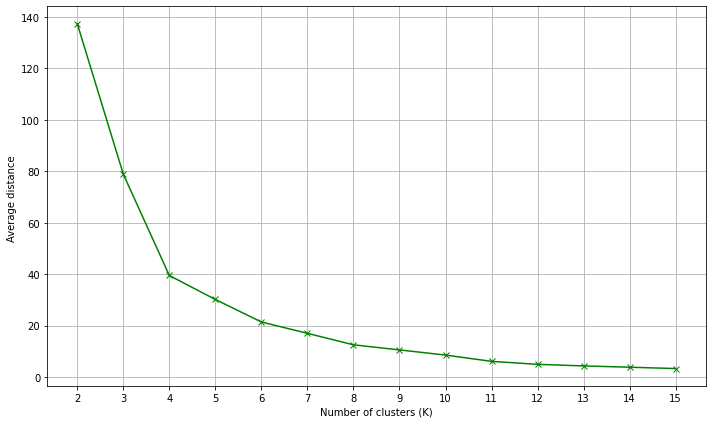

In [143]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2,Ks),inertia,'gx-')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#plt.scatter(8, inertia[7], marker='o', color='g', s=100)
#bbox_props = dict(boxstyle="larrow,pad=0.6", fc="white", ec="g", lw=2)
#t = ax.text(11, 20, "Elbow point (K = 8)", ha="center", va="center", rotation=37,
#            size=15,
#            bbox=bbox_props)
plt.grid(True)
plt.tight_layout()
plt.show()

In [144]:
# set number of clusters
kclusters = 4

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(neighborhood_clustering)
kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(scaled_sales)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 3, 3, 0, 3, 0, 3], dtype=int32)

In [145]:
df_cluster_shops.insert(0, 'shop_cluster', kmeans.labels_)
df_cluster_shops = df_cluster_shops[['shop_id', 'shop_cluster']].set_index('shop_id')
df_cluster_shops.head()

,shop_cluster
shop_id,
2,0
3,0
4,0
5,0
6,3


In [146]:
shop_clusters = {}

def get_shop_cluster(shop_id):
    if shop_id not in shop_clusters:
        shop_clusters[shop_id] = df_cluster_shops.loc[shop_id]['shop_cluster']
    return shop_clusters[shop_id]

### Cluster analysis for cities

In [147]:
#df_sales_items = df_sales.groupby(['date_block_num','shop_id'])['item_cnt_day'].sum().reset_index()
#df_sales_items['month'] = df_sales_items['date_block_num'] % 12 + 1
df_sales_items['city'] = df_sales_items['shop_id'].apply(lambda x: get_shop_city(x))
df_sales_items.head()

,date_block_num,shop_id,item_cnt_day,month,city
0,0,2,1146.00000,1,Адыгея
1,0,3,767.00000,1,Балашиха
2,0,4,2114.00000,1,Волжский
3,0,6,3686.00000,1,Воронеж
4,0,7,2495.00000,1,Воронеж


In [148]:
# for clustrer analysis
df_cluster_sales = df_sales_items.groupby(['month','city'])['item_cnt_day'].mean().to_frame(name='item_cnt_month').reset_index()
df_cluster_sales.head(10)

,month,city,item_cnt_month
0,1,Адыгея,1007.66667
1,1,Балашиха,904.00000
2,1,Волжский,1577.33333
3,1,Вологда,1521.50000
4,1,Воронеж,2489.85714
5,1,Жуковский,782.33333
6,1,Интернет,1592.33333
7,1,Казань,1316.00000
8,1,Калуга,2410.00000
9,1,Коломна,2196.33333


In [149]:
# for clustrer analysis
df_cluster_cities = df_cluster_sales.pivot_table(index=['city'], columns=['month'], values=['item_cnt_month'], fill_value=0)
df_cluster_cities.reset_index(inplace=True)
df_cluster_cities.columns = [ ''.join((name, str(date))) for (name, date) in df_cluster_cities.columns.values]
df_cluster_cities.head()

,city,item_cnt_month1,item_cnt_month2,item_cnt_month3,item_cnt_month4,item_cnt_month5,item_cnt_month6,item_cnt_month7,item_cnt_month8,item_cnt_month9,item_cnt_month10,item_cnt_month11,item_cnt_month12
0,Адыгея,1007.66667,768.66667,835.00000,744.33333,768.66667,864.33333,810.00000,924.33333,895.66667,822.33333,1027.00000,1621.50000
1,Балашиха,904.00000,803.00000,935.00000,690.66667,739.00000,761.33333,671.33333,819.33333,910.33333,737.00000,1016.50000,1204.50000
2,Волжский,1577.33333,1434.66667,1428.00000,779.66667,1142.66667,1156.66667,1103.66667,1349.00000,1119.33333,1164.33333,1428.50000,2159.50000
3,Вологда,1521.50000,1076.66667,1311.66667,1039.00000,1109.33333,1224.33333,1220.00000,1446.66667,1248.33333,1168.66667,1417.50000,2175.00000
4,Воронеж,2489.85714,2476.85714,2357.71429,1826.00000,1988.16667,2223.16667,2078.00000,2274.50000,2381.83333,2188.50000,2913.25000,4157.75000


In [150]:
#cluster analysis
from sklearn.preprocessing import StandardScaler
df_cluster_without_cities = df_cluster_cities.drop('city', axis=1)
scaled_sales = StandardScaler().fit_transform(df_cluster_without_cities.values)
scaled_sales.shape

(31, 12)

In [151]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

SEED = 579

#neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# set number of clusters
Ks = 16
inertia = np.zeros((Ks-2))
for n in range(2,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(init='k-means++', n_clusters=n, random_state=SEED, algorithm="full").fit(scaled_sales)
    inertia[n-2] = kmeans.inertia_
inertia

array([155.69515854,  88.57575893,  53.1909822 ,  31.13420766,
        18.26961252,  13.15250172,  10.05189243,   7.95945857,
         6.32516435,   5.05445662,   4.07357843,   3.29410202,
         2.84431957,   2.38059402])

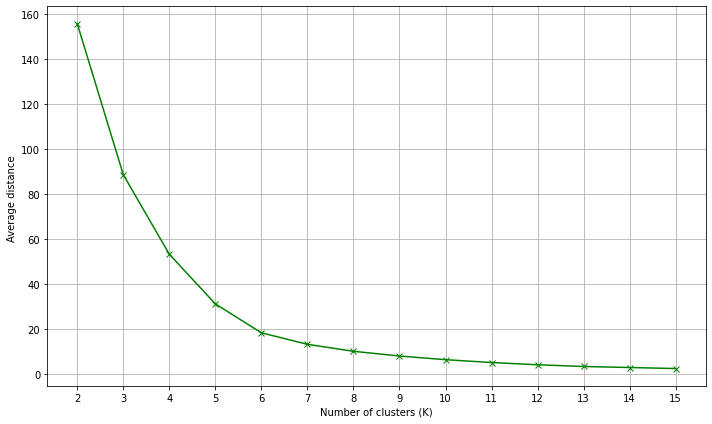

In [152]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2,Ks),inertia,'gx-')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#plt.scatter(8, inertia[7], marker='o', color='g', s=100)
#bbox_props = dict(boxstyle="larrow,pad=0.6", fc="white", ec="g", lw=2)
#t = ax.text(11, 20, "Elbow point (K = 8)", ha="center", va="center", rotation=37,
#            size=15,
#            bbox=bbox_props)
plt.grid(True)
plt.tight_layout()
plt.show()

In [153]:
# set number of clusters
kclusters = 6

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(neighborhood_clustering)
kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(scaled_sales)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 3, 3, 4, 5, 0, 4, 3, 4], dtype=int32)

In [154]:
df_cluster_cities.insert(0, 'city_cluster', kmeans.labels_)
df_cluster_cities = df_cluster_cities[['city', 'city_cluster']].set_index('city')
df_cluster_cities.head(10)

,city_cluster
city,
Адыгея,0
Балашиха,0
Волжский,3
Вологда,3
Воронеж,4
Выездная,5
Жуковский,0
Интернет,4
Казань,3


In [155]:
city_clusters = {}

def get_city_cluster(city):
    if city not in city_clusters:
        city_clusters[city] = df_cluster_cities.loc[city]['city_cluster']
    return city_clusters[city]

## Cluster analysis for categories

In [156]:
df_sales_items = df_sales.groupby(['date_block_num','shop_id', 'category'])['item_cnt_day'].sum().reset_index()
df_sales_items['month'] = df_sales_items['date_block_num'] % 12 + 1
df_sales_items.head()

,date_block_num,shop_id,category,item_cnt_day,month
0,0,2,Аксессуары - PS3,25.00000,1
1,0,2,Аксессуары - PS4,9.00000,1
2,0,2,Аксессуары - PSP,10.00000,1
3,0,2,Аксессуары - PSVita,10.00000,1
4,0,2,Аксессуары - XBOX 360,12.00000,1


In [157]:
# for clustrer analysis
df_cluster_sales = df_sales.groupby(['month','category'])['item_cnt_day'].mean().to_frame(name='item_cnt_month').reset_index()
df_cluster_sales.head(10)

,month,category,item_cnt_month
0,1,PC - Гарнитуры/Наушники,1.00000
1,1,Аксессуары - PS2,1.00000
2,1,Аксессуары - PS3,2.35665
3,1,Аксессуары - PS4,3.59714
4,1,Аксессуары - PSP,1.85938
5,1,Аксессуары - PSVita,1.69014
6,1,Аксессуары - XBOX 360,2.93394
7,1,Аксессуары - XBOX ONE,2.46718
8,1,Доставка товара,48.37500
9,1,Игровые консоли - PS3,2.19495


In [158]:
# for clustrer analysis
df_cluster_categories = df_cluster_sales.pivot_table(index=['category'], columns=['month'], values=['item_cnt_month'], fill_value=0)
df_cluster_categories.reset_index(inplace=True)
df_cluster_categories.columns = [ ''.join((name, str(date))) for (name, date) in df_cluster_categories.columns.values]
df_cluster_categories.head()

,category,item_cnt_month1,item_cnt_month2,item_cnt_month3,item_cnt_month4,item_cnt_month5,item_cnt_month6,item_cnt_month7,item_cnt_month8,item_cnt_month9,item_cnt_month10,item_cnt_month11,item_cnt_month12
0,PC - Гарнитуры/Наушники,1.00000,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,Аксессуары - PS2,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,Аксессуары - PS3,2.35665,1.96922,1.78645,1.55399,1.51469,1.53602,1.53399,1.56831,1.54887,1.56675,1.73292,2.84758
3,Аксессуары - PS4,3.59714,3.85932,2.96505,2.56667,2.37792,2.50641,2.64142,2.71792,3.00764,2.80589,3.08746,5.35588
4,Аксессуары - PSP,1.85938,1.86111,1.85714,1.64167,1.52778,1.75000,1.84426,1.85263,1.64615,1.58904,1.87755,1.65000


In [159]:
#cluster analysis
from sklearn.preprocessing import StandardScaler
df_cluster_without_categories = df_cluster_categories.drop('category', axis=1)
scaled_sales = StandardScaler().fit_transform(df_cluster_without_categories.values)
scaled_sales.shape

(84, 12)

In [160]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

SEED = 579

#neighborhood_clustering = df_neighborhood_categories.drop('Neighborhood', axis=1)

# set number of clusters
Ks = 16
inertia = np.zeros((Ks-2))
for n in range(2,Ks):
    
    #Train Model and Predict  
    kmeans = KMeans(init='k-means++', n_clusters=n, random_state=SEED, algorithm="full").fit(scaled_sales)
    inertia[n-2] = kmeans.inertia_
inertia

array([174.38291586,  86.98851414,  44.79922857,  17.85800957,
         9.55633198,   6.4163758 ,   3.90717746,   3.06550487,
         2.55147792,   2.14484346,   1.65362508,   1.28144406,
         0.99991063,   0.83966163])

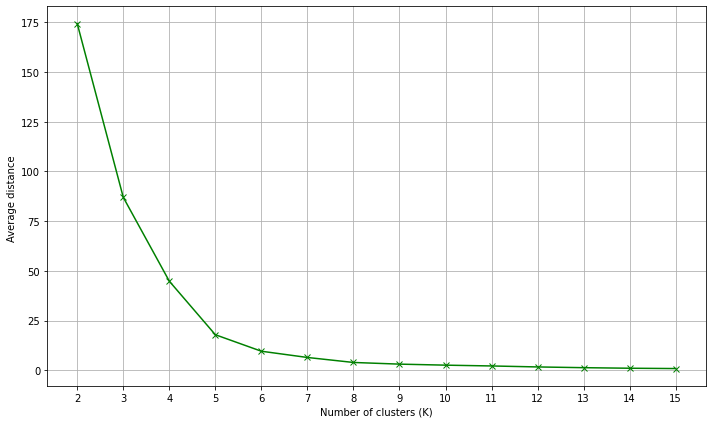

In [161]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(range(2,Ks),inertia,'gx-')
plt.ylabel('Average distance ')
plt.xlabel('Number of clusters (K)')
loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
#plt.scatter(8, inertia[7], marker='o', color='g', s=100)
#bbox_props = dict(boxstyle="larrow,pad=0.6", fc="white", ec="g", lw=2)
#t = ax.text(11, 20, "Elbow point (K = 8)", ha="center", va="center", rotation=37,
#            size=15,
#            bbox=bbox_props)
plt.grid(True)
plt.tight_layout()
plt.show()

In [162]:
# set number of clusters
kclusters = 5

# run k-means clustering 
#kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(neighborhood_clustering)
kmeans = KMeans(n_clusters=kclusters, random_state=SEED).fit(scaled_sales)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 4, 3], dtype=int32)

In [163]:
df_cluster_categories.insert(0, 'category_cluster', kmeans.labels_)
df_cluster_categories = df_cluster_categories[['category', 'category_cluster']].set_index('category')
df_cluster_categories.head()

,category_cluster
category,
PC - Гарнитуры/Наушники,0
Аксессуары - PS2,0
Аксессуары - PS3,0
Аксессуары - PS4,0
Аксессуары - PSP,0


In [164]:
category_clusters = {}

def get_category_cluster(category):
    if category not in category_clusters:
        category_clusters[category] = df_cluster_categories.loc[category]['category_cluster']
    return category_clusters[category]

## Model

In [165]:
#df_monthly_sales = df_sales.groupby(['date_block_num','shop_id','item_id'])[['item_cnt_day', 'revenue']].sum().reset_index()#.to_frame(name='item_cnt_month').reset_index()
#df_monthly_sales = df_sales.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum().to_frame(name='item_cnt_month').reset_index()
df_monthly_sales = df_sales.copy()
df_monthly_sales.head(10)

,date_block_num,shop_id,item_id,item_cnt_day,revenue,shop_type,category,city,month
0,0,2,27,1.00000,2499.00000,ТЦ,Игры - PS3,Адыгея,1
1,0,2,33,1.00000,499.00000,ТЦ,Кино - Blu-Ray,Адыгея,1
2,0,2,317,1.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
3,0,2,438,1.00000,299.00000,ТЦ,Книги - Аудиокниги 1С,Адыгея,1
4,0,2,471,2.00000,798.00000,ТЦ,Книги - Методические материалы 1С,Адыгея,1
5,0,2,481,1.00000,330.00000,ТЦ,Книги - Методические материалы 1С,Адыгея,1
6,0,2,482,1.00000,3300.00000,ТЦ,Программы - 1С:Предприятие 8,Адыгея,1
7,0,2,484,2.00000,600.00000,ТЦ,Программы - 1С:Предприятие 8,Адыгея,1
8,0,2,491,1.00000,600.00000,ТЦ,Программы - 1С:Предприятие 8,Адыгея,1
9,0,2,534,2.00000,798.00000,ТЦ,Программы - Обучающие,Адыгея,1


In [166]:
df_monthly_sales.loc[(df_monthly_sales['date_block_num']==0) & (df_monthly_sales['item_id'] == 2552) & (df_monthly_sales['shop_id'] == 25)]

,date_block_num,shop_id,item_id,item_cnt_day,revenue,shop_type,category,city,month
19545,0,25,2552,0.00000,0.00000,ТРК,Музыка - Винил,Москва,1


In [167]:
# clip all cnt
#df_monthly_sales['item_cnt_day'] = np.clip(df_monthly_sales['item_cnt_day'], 0, 20)

In [168]:
df_monthly_sales.describe()

,date_block_num,shop_id,item_id,item_cnt_day,revenue,month
count,1608272.00000,1608272.00000,1608272.00000,1608272.00000,1608272.00000,1608272.00000
mean,14.66207,33.08813,10680.81598,2.26840,2113.40267,6.15391
std,9.54382,16.47024,6238.71724,8.65779,15321.22651,3.45497
min,0.00000,2.00000,0.00000,-22.00000,-33787.00000,1.00000
25%,6.00000,21.00000,5046.00000,1.00000,249.00000,3.00000
50%,14.00000,31.00000,10497.00000,1.00000,537.00000,6.00000
75%,23.00000,48.00000,16060.00000,2.00000,1490.00000,9.00000
max,33.00000,59.00000,22169.00000,2253.00000,6264230.00000,12.00000


In [169]:
df = df_monthly_sales.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values='item_cnt_day', fill_value=0)
#df = df_monthly_sales.pivot_table(index=['shop_id','item_id'], columns=['date_block_num'], values=['item_cnt_day', 'revenue'], fill_value=0)
df.reset_index(inplace=True)
df.head()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,24,25,26,27,28,29,30,31,32,33
0,2,27,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,30,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,31,0,4,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2,32,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
4,2,33,1,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,0,1,0


In [170]:
#df.columns = [ ''.join((name, str(date))) for (name, date) in df.columns.values]
#df['item_cnt_day34'] = np.nan
#df['revenue34'] = np.nan
df[34] = np.nan
df.describe()

date_block_num,shop_id,item_id,0,1,2,3,4,5,6,7,...,25,26,27,28,29,30,31,32,33,34
count,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,...,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,418226.00000,0.00000
mean,31.96317,11458.02437,0.31437,0.30627,0.35182,0.25630,0.25577,0.29979,0.27967,0.29958,...,0.20132,0.19610,0.18609,0.17286,0.15330,0.15108,0.15800,0.17417,0.16990,nan
std,16.70215,6133.50254,1.52184,1.61007,2.06599,1.36924,2.02436,3.34233,2.75611,2.93574,...,1.53860,1.50277,3.60501,2.86066,1.71125,1.58824,1.60870,4.95418,4.03456,nan
min,2.00000,0.00000,-13.00000,-4.00000,-2.00000,-2.00000,-1.00000,-1.00000,-2.00000,-2.00000,...,-1.00000,-2.00000,-1.00000,-1.00000,-1.00000,-1.00000,-2.00000,-1.00000,-1.00000,nan
25%,18.00000,6246.25000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan
50%,30.00000,11614.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan
75%,47.00000,16662.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,nan
max,59.00000,22169.00000,169.00000,130.00000,259.00000,175.00000,504.00000,766.00000,799.00000,820.00000,...,300.00000,291.00000,1242.00000,742.00000,444.00000,482.00000,436.00000,1644.00000,2253.00000,nan


In [171]:
df_test = pd.merge(df_test, df, on=['shop_id','item_id'], how='left')
df_test = df_test.fillna(0)
df_test.head()

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,25,26,27,28,29,30,31,32,33,34
0,0,5,5037,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000,3.00000,1.00000,0.00000,0.00000
1,1,5,5320,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,2,5,5233,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,3.00000,2.00000,0.00000,1.00000,3.00000,1.00000,0.00000
3,3,5,5232,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
4,4,5,5268,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [172]:
df_test.drop(['ID'], axis=1, inplace=True)

In [173]:
# calc prev month
df_test['prev0'] = np.nan
df_test['prev_diff0'] = np.nan
df_test['mean3_0'] = np.nan
df_test['mean6_0'] = np.nan
#df_test['prev_year0'] = np.nan
#df_test['revenue_prev0'] = np.nan
#df_test['revenue_prev_diff0'] = np.nan
#df_test['revenue_prev_year0'] = np.nan
for col in range(1, 35):
    df_test[''.join(('prev', str(col)))] = df_test[col-1]
    df_test[''.join(('prev_diff', str(col)))] = df_test[col] - df_test[col-1]
    df_test[''.join(('mean3_', str(col)))] = np.nan
    if col > 2:
        df_test[''.join(('mean3_', str(col)))] = (df_test[col-1] + df_test[col-2] + df_test[col-3])/3
    df_test[''.join(('mean6_', str(col)))] = np.nan
    if col > 5:
        df_test[''.join(('mean6_', str(col)))] = (df_test[col-1] + df_test[col-2] + df_test[col-3] + df_test[col-4] + df_test[col-5] + df_test[col-6])/6
        
#    df_test[''.join(('revenue_prev_year', str(col)))] = np.nan
#    df_test[''.join(('prev_year', str(col)))] = np.nan
#    if col > 11:
#        df_test[''.join(('prev_year', str(col)))] = df_test[col-12]
#        df_test[''.join(('revenue_prev_year', str(col)))] = df_test[''.join(('revenue', str(col-12)))]
#    df_test[''.join(('revenue_prev', str(col)))] = df_test[''.join(('revenue', str(col-1)))]
#    df_test[''.join(('revenue_prev_diff', str(col)))] = df_test[''.join(('revenue_prev', str(col)))] - df_test[''.join(('revenue_prev', str(col-1)))]
        
df_test.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,mean3_32,mean6_32,prev33,prev_diff33,mean3_33,mean6_33,prev34,prev_diff34,mean3_34,mean6_34
0,5,5037,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.66667,1.00000,1.00000,-1.00000,1.66667,1.16667,0.00000,0.00000,1.33333,1.16667
1,5,5320,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,5,5233,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,1.00000,3.00000,-2.00000,1.33333,1.50000,1.00000,-1.00000,1.66667,1.66667
3,5,5232,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.33333,0.16667,0.00000,0.00000,0.33333,0.16667,0.00000,0.00000,0.33333,0.16667
4,5,5268,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [174]:
# calc quarts
for col in range(2, 35):
    if (col+1)%3 == 0:
        q = (col+1)//3
        df_test[''.join(('Q', str(q)))] = df_test[col] + df_test[col-1] + df_test[col-2]
        #df_test[''.join(('revenueQ', str(q)))] = df_test[''.join(('revenue', str(col)))] + df_test[''.join(('revenue', str(col-1)))] + df_test[''.join(('revenue', str(col-2)))]
df_test.head()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11
0,5,5037,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,3.00000,2.00000,2.00000,5.00000
1,5,5320,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,5,5233,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,5.00000,4.00000
3,5,5232,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000
4,5,5268,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [175]:
#df_test[[''.join(('itemQ', str(q))) for q in range(1,12)]].describe()
df_test[[''.join(('prev_diff', str(q))) for q in range(35)]].describe()

,prev_diff0,prev_diff1,prev_diff2,prev_diff3,prev_diff4,prev_diff5,prev_diff6,prev_diff7,prev_diff8,prev_diff9,...,prev_diff25,prev_diff26,prev_diff27,prev_diff28,prev_diff29,prev_diff30,prev_diff31,prev_diff32,prev_diff33,prev_diff34
count,0.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,...,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000
mean,nan,0.00898,0.03505,-0.05086,0.01222,0.04287,-0.01188,0.01113,0.05489,-0.02030,...,-0.06016,-0.00100,0.01911,-0.01200,-0.02135,0.00235,0.03395,-0.00352,0.01879,-0.29341
std,nan,1.13815,1.77047,1.45152,1.90178,2.91128,1.55686,1.38058,3.26380,2.38535,...,3.43059,1.51613,3.95414,4.12676,2.77430,1.05556,1.18033,1.58526,4.76758,5.55098
min,nan,-146.00000,-77.00000,-205.00000,-110.00000,-69.00000,-462.00000,-267.00000,-227.00000,-353.00000,...,-1000.00000,-257.00000,-151.00000,-808.00000,-540.00000,-97.00000,-126.00000,-102.00000,-135.00000,-2253.00000
25%,nan,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,nan,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,nan,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,nan,117.00000,259.00000,151.00000,497.00000,683.00000,49.00000,229.00000,548.00000,263.00000,...,126.00000,148.00000,813.00000,550.00000,92.00000,62.00000,144.00000,171.00000,2007.00000,1.00000


In [176]:
df_test.columns.values

array(['shop_id', 'item_id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 'prev0', 'prev_diff0', 'mean3_0', 'mean6_0',
       'prev1', 'prev_diff1', 'mean3_1', 'mean6_1', 'prev2', 'prev_diff2',
       'mean3_2', 'mean6_2', 'prev3', 'prev_diff3', 'mean3_3', 'mean6_3',
       'prev4', 'prev_diff4', 'mean3_4', 'mean6_4', 'prev5', 'prev_diff5',
       'mean3_5', 'mean6_5', 'prev6', 'prev_diff6', 'mean3_6', 'mean6_6',
       'prev7', 'prev_diff7', 'mean3_7', 'mean6_7', 'prev8', 'prev_diff8',
       'mean3_8', 'mean6_8', 'prev9', 'prev_diff9', 'mean3_9', 'mean6_9',
       'prev10', 'prev_diff10', 'mean3_10', 'mean6_10', 'prev11',
       'prev_diff11', 'mean3_11', 'mean6_11', 'prev12', 'prev_diff12',
       'mean3_12', 'mean6_12', 'prev13', 'prev_diff13', 'mean3_13',
       'mean6_13', 'prev14', 'prev_diff14', 'mean3_14', 'mean6_14',
       'prev15', 'prev_diff15', 'mean3_15', 'mean6_15', 'prev1

In [177]:
df_test.describe()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,Q11
count,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,...,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000,214200.00000
mean,31.64286,11019.39863,0.10349,0.11247,0.14752,0.09666,0.10888,0.15175,0.13987,0.15100,...,0.35729,0.49676,0.71157,0.62667,0.58436,0.68172,1.06556,0.83042,0.78023,0.79695
std,17.56193,6252.64459,1.05727,1.15860,1.81539,0.95285,2.02680,3.96538,3.19018,3.29518,...,5.93276,10.32254,12.94648,9.20194,7.79756,8.12182,12.15665,6.43048,8.65632,6.31807
min,2.00000,30.00000,-2.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-2.00000,...,-1.00000,-2.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000
25%,16.00000,5381.50000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
50%,34.50000,11203.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
75%,47.00000,16071.50000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
max,59.00000,22167.00000,169.00000,117.00000,259.00000,151.00000,504.00000,766.00000,799.00000,820.00000,...,1160.00000,2569.00000,3272.00000,2616.00000,1824.00000,1758.00000,2615.00000,1000.00000,1418.00000,1391.00000


In [178]:
%%time
df_test['shop_type'] = df_test['shop_id'].apply(lambda x: get_shop_type(x))

CPU times: user 123 ms, sys: 1.94 ms, total: 125 ms
Wall time: 124 ms


In [179]:
%%time
df_test['shop_mega'] = df_test['shop_id'].apply(lambda x: get_shop_megality(x))

CPU times: user 256 ms, sys: 5 ms, total: 261 ms
Wall time: 260 ms


In [180]:
%%time
df_test['shop_cluster'] = df_test['shop_id'].apply(lambda x: get_shop_cluster(x))

CPU times: user 255 ms, sys: 2.16 ms, total: 257 ms
Wall time: 256 ms


In [181]:
%%time
df_test['subcategory'] = df_test['item_id'].apply(lambda x: get_category(x))

CPU times: user 440 ms, sys: 2.19 ms, total: 442 ms
Wall time: 444 ms


In [182]:
%%time
df_test['digital'] = df_test['item_id'].apply(lambda x: get_category_digitality(x))

CPU times: user 431 ms, sys: 3.06 ms, total: 434 ms
Wall time: 433 ms


In [183]:
%%time
df_test['city'] = df_test['shop_id'].apply(lambda x: get_shop_city(x))

CPU times: user 124 ms, sys: 2.96 ms, total: 127 ms
Wall time: 125 ms


In [184]:
%%time
df_test['city_cluster'] = df_test['city'].apply(lambda x: get_city_cluster(x))

CPU times: user 246 ms, sys: 5.87 ms, total: 252 ms
Wall time: 250 ms


In [185]:
%%time
df_test['category_cluster'] = df_test['subcategory'].apply(lambda x: get_category_cluster(x))

CPU times: user 241 ms, sys: 4.96 ms, total: 246 ms
Wall time: 246 ms


In [186]:
df_test['category'] = df_test['subcategory'].str.split('[-(]', n=0).str[0].str.strip()

In [187]:
#%%time
#df_sells_in_month['month'] = df_sells_in_month['date_block_num']%12 + 1

In [188]:
# clip all
#df_sells_in_month['item_cnt_prev_month'] = np.clip(df_sells_in_month['item_cnt_prev_month'], 0, 20)
#df_sells_in_month['item_cnt_month'] = np.clip(df_sells_in_month['item_cnt_month'], 0, 20)

#df_sells_in_month['prev_itemQ'].describe()

In [189]:
df_test.tail()

,shop_id,item_id,0,1,2,3,4,5,6,7,...,Q11,shop_type,shop_mega,shop_cluster,subcategory,digital,city,city_cluster,category_cluster,category
214195,45,18454,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,ТЦ,0,0,Музыка - CD локального производства,0,Самара,3,0,Музыка
214196,45,16188,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,ТЦ,0,0,Подарки - Настольные игры,0,Самара,3,0,Подарки
214197,45,15757,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,ТЦ,0,0,Музыка - CD локального производства,0,Самара,3,0,Музыка
214198,45,19648,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,ТЦ,0,0,Кино - DVD,0,Самара,3,0,Кино
214199,45,969,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,ТЦ,0,0,Кино - Blu-Ray,0,Самара,3,0,Кино


In [190]:
df_test.columns.values

array(['shop_id', 'item_id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
       14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30,
       31, 32, 33, 34, 'prev0', 'prev_diff0', 'mean3_0', 'mean6_0',
       'prev1', 'prev_diff1', 'mean3_1', 'mean6_1', 'prev2', 'prev_diff2',
       'mean3_2', 'mean6_2', 'prev3', 'prev_diff3', 'mean3_3', 'mean6_3',
       'prev4', 'prev_diff4', 'mean3_4', 'mean6_4', 'prev5', 'prev_diff5',
       'mean3_5', 'mean6_5', 'prev6', 'prev_diff6', 'mean3_6', 'mean6_6',
       'prev7', 'prev_diff7', 'mean3_7', 'mean6_7', 'prev8', 'prev_diff8',
       'mean3_8', 'mean6_8', 'prev9', 'prev_diff9', 'mean3_9', 'mean6_9',
       'prev10', 'prev_diff10', 'mean3_10', 'mean6_10', 'prev11',
       'prev_diff11', 'mean3_11', 'mean6_11', 'prev12', 'prev_diff12',
       'mean3_12', 'mean6_12', 'prev13', 'prev_diff13', 'mean3_13',
       'mean6_13', 'prev14', 'prev_diff14', 'mean3_14', 'mean6_14',
       'prev15', 'prev_diff15', 'mean3_15', 'mean6_15', 'prev1

In [270]:
#const_cols = ['shop_cluster', 'city_cluster', 'category_cluster']
const_cols = ['shop_cluster', 'city_cluster', 'category_cluster', 'shop_type', 'subcategory', 'category', 'city', 'shop_mega', 'digital']
train_cols = [item for sublist in [[''.join(('prev', str(q)))
                       , ''.join(('prev_diff', str(q)))
                       , ''.join(('mean3_', str(q)))
                      , ''.join(('mean6_', str(q)))] 
                      for q in range(6, 33)] for item in sublist]
test_cols = [item for sublist in [[''.join(('prev', str(q)))
                       , ''.join(('prev_diff', str(q)))
                       , ''.join(('mean3_', str(q)))
                      , ''.join(('mean6_', str(q)))] 
                      for q in range(7, 34)] for item in sublist]
pred_cols = [item for sublist in [[''.join(('prev', str(q)))
                       , ''.join(('prev_diff', str(q)))
                       , ''.join(('mean3_', str(q)))
                      , ''.join(('mean6_', str(q)))] 
                      for q in range(8, 35)] for item in sublist]
X_const = df_test[const_cols]
X_train_data = df_test[train_cols]
X_test_data = df_test[test_cols]
X_pred_data = df_test[pred_cols]
Y_train = df_test[32]
Y_test = df_test[33]
X_train_data.head()
#np.array([const_cols,test_cols]).flatten()
#const_cols + test_cols
#flat_list = const_cols + [item for sublist in test_cols for item in sublist]
#flat_list

,prev6,prev_diff6,mean3_6,mean6_6,prev7,prev_diff7,mean3_7,mean6_7,prev8,prev_diff8,...,mean3_30,mean6_30,prev31,prev_diff31,mean3_31,mean6_31,prev32,prev_diff32,mean3_32,mean6_32
0,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.66667,0.66667,1.00000,2.00000,1.00000,0.50000,3.00000,-2.00000,1.66667,1.00000
1,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.66667,0.83333,0.00000,1.00000,1.66667,0.83333,1.00000,2.00000,1.00000,1.00000
3,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,1.00000,-1.00000,0.33333,0.16667
4,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [243]:
df_test[[32,33]].describe()

,32,33
count,214200.00000,214200.00000
mean,0.27462,0.29341
std,2.49898,5.55098
min,-1.00000,-1.00000
25%,0.00000,0.00000
50%,0.00000,0.00000
75%,0.00000,0.00000
max,473.00000,2253.00000


In [244]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score

date_ix = 0

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attributes_names):
        self.attributes_names = attributes_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attributes_names].values # convert to NumPy array

class CycleTransformator( BaseEstimator, TransformerMixin):
    #Class Constructor 
    def __init__( self,  cycle_columns ):
        self._cycle_columns = cycle_columns
        self._cycle_stats = {}
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        for column in self._cycle_columns:
            self._cycle_stats[column] = { 'max': X[column].max(), 'min': X[column].min() }
        return self
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        self._df = pd.DataFrame(index=X.index)
        for column in self._cycle_columns:
            self._df[column+'_sin'] = np.sin(2*np.pi/(self._cycle_stats[column]['max']+1)*X[column].fillna(self._cycle_stats[column]['min']-1))
            self._df[column+'_cos'] = np.cos(2*np.pi/(self._cycle_stats[column]['max']+1)*X[column].fillna(self._cycle_stats[column]['min']-1))

        #self._df = self._df.reset_index(drop=True)
        #print('Cycle transform shape is {}'.format(self._df.values.shape))
        return self._df.values

In [245]:
import sklearn.metrics as metrics
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [246]:
from sklearn.metrics import make_scorer

def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

In [271]:
#num_attribs = ['item_cnt_prev_month','item_cnt_prev_diff','prev_itemQ','item_cnt_prev_year']
num_attribs = ['prev_month','prev_diff', 'prev_itemQ', 'mean3', 'mean6']
#num_attribs = ['digital']
#cat_attribs = ['shop_cluster', 'category_cluster']
#cat_attribs = ['city_cluster','shop_cluster', 'category_cluster']
#cat_attribs = ['shop_type', 'subcategory', 'category', 'city', 'shop_mega', 'digital']
cat_attribs = ['city_cluster','shop_cluster', 'category_cluster', 'shop_type', 'subcategory', 'category', 'city', 'shop_mega', 'digital']
#cat_attribs = ['shop_type', 'category', 'city']
#cat_attribs = ['city_cluster','shop_cluster', 'category_cluster', 'shop_type', 'category']
#cat_attribs = ['shop_cluster', 'category']
#num_attribs = ['item_id','shop_id','digital']
#cat_attribs = ['category']
date_attribs = ['month']

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', SimpleImputer(strategy="median")),
#    ('std_scaler', StandardScaler()),
])
cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])
counted_pipeline = Pipeline([
    ('cycle_transformator', CycleTransformator(cycle_columns=date_attribs)),
])

full_pipeline = FeatureUnion(transformer_list=[
#    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline),
#    ('counted_pipeline', counted_pipeline),
])

In [272]:
from sklearn.model_selection import TimeSeriesSplit

'''
df_sells_in_month = df_sells_in_month.dropna()

#X_train_data = df_sells_in_month[df_sells_in_month['date_block_num'] < 24].copy()
#X_test_data = df_sells_in_month[df_sells_in_month['date_block_num'] > 23].copy()
#X_train = X_train_data[['item_cnt_prev_month','revenue_prev', 'item_cnt_prev_diff','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_type', 'shop_mega', 'shop_cluster', 'city', 'city_cluster', 'category', 'subcategory', 'digital', 'category_cluster', 'month']]
#X_test = X_test_data[['item_cnt_prev_month','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_type', 'shop_mega', 'shop_cluster', 'city', 'city_cluster', 'category', 'subcategory', 'digital', 'category_cluster', 'month']]

#X_train = X_train_data[['item_cnt_prev_month','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_cluster', 'city_cluster', 'category_cluster', 'month']]
#X_test = X_test_data[['item_cnt_prev_month','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_cluster', 'city_cluster', 'category_cluster', 'month']]

X_train = df_sells_in_month[df_sells_in_month['date_block_num'] < 24].copy()
X_test = df_sells_in_month[(df_sells_in_month['date_block_num'] > 23) & (df_sells_in_month['date_block_num'] < 34)].copy()
X_pred = df_sells_in_month[df_sells_in_month['date_block_num'] == 34].copy()


Y_train = X_train['item_cnt_month'].copy()
Y_test = X_test['item_cnt_month'].copy()

tscv = TimeSeriesSplit(n_splits=5)
'''

"\ndf_sells_in_month = df_sells_in_month.dropna()\n\n#X_train_data = df_sells_in_month[df_sells_in_month['date_block_num'] < 24].copy()\n#X_test_data = df_sells_in_month[df_sells_in_month['date_block_num'] > 23].copy()\n#X_train = X_train_data[['item_cnt_prev_month','revenue_prev', 'item_cnt_prev_diff','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_type', 'shop_mega', 'shop_cluster', 'city', 'city_cluster', 'category', 'subcategory', 'digital', 'category_cluster', 'month']]\n#X_test = X_test_data[['item_cnt_prev_month','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_type', 'shop_mega', 'shop_cluster', 'city', 'city_cluster', 'category', 'subcategory', 'digital', 'category_cluster', 'month']]\n\n#X_train = X_train_data[['item_cnt_prev_month','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_cluster', 'city_cluster', 'category_cluster', 'month']]\n#X_test = X_test_data[['item_cnt_prev_month','revenue_prev', 'prev_itemQ', 'prev_revenueQ', 'shop_cluster', 'city_cluster', 'cat

In [273]:
#X_train['date_block_num'].unique()

In [274]:
#Y_train.describe()

In [275]:
#Y_test.describe()

In [276]:
X_prepared = full_pipeline.fit_transform(X_const)
X_prepared.shape

(214200, 128)

In [277]:
X_train = np.concatenate((X_prepared, X_train_data), axis=1)
X_train.shape

(214200, 236)

In [278]:
X_test = np.concatenate((X_prepared, X_test_data), axis=1)
X_test.shape

(214200, 236)

In [279]:
X_pred = np.concatenate((X_prepared, X_pred_data), axis=1)
X_pred.shape

(214200, 236)

In [259]:
#from sklearn.preprocessing import PolynomialFeatures

#poly = PolynomialFeatures(degree=2)
#X_train_prepared = poly.fit_transform(X_train_prepared)
#X_test_prepared = poly.transform(X_test_prepared)
#X_train_prepared.shape

In [260]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Std Deviation:", scores.std())

In [280]:
%%time

from sklearn.tree import DecisionTreeRegressor

# train
tree_reg = DecisionTreeRegressor(random_state=57)
tree_reg.fit(X_train, Y_train)

# predict
predictions = tree_reg.predict(X_train)

#scores = cross_val_score(tree_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2")
#print('%s: %f (%f)' % ('Tree: ', scores.mean(), scores.std()))
#tree_rmse_scores = np.sqrt(-scores)
#display_scores(tree_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = tree_reg.predict(X_test)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))
#regression_results(Y_pred , Y_test)

R2-score: 1.00
Testing...
R2-score: 0.25
MSE: 23.242628
CPU times: user 17.3 s, sys: 220 ms, total: 17.5 s
Wall time: 17.7 s


In [281]:
%%time
from sklearn.linear_model import LinearRegression

# train
lin_reg = LinearRegression()
lin_reg.fit(X_train, Y_train)
# predict
predictions = lin_reg.predict(X_train)

#scores = cross_val_score(lin_reg, X_train, Y_train, cv=tscv, scoring="r2")
#print('%s: %f (%f)' % ('LinReg: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = lin_reg.predict(X_test)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))
#regression_results(Y_test, Y_pred)

R2-score: 1.00
Testing...
R2-score: 1.00
MSE: 0.000000
CPU times: user 16.9 s, sys: 5.39 s, total: 22.3 s
Wall time: 10.8 s


In [282]:
%%time
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=57, n_jobs=4, verbose=1)
print('Fitting...')
forest_reg.fit(X_train, Y_train)
# predict
print('Predicting...')
predictions = forest_reg.predict(X_train)

#print('Cross validating...')
#scores = cross_val_score(forest_reg, X_train_prepared, Y_train, cv=tscv, scoring="r2", n_jobs=4, verbose=1)
#print('%s: %f (%f)' % ('Forest: ', scores.mean(), scores.std()))
#forest_rmse_scores = np.sqrt(-scores)
#display_scores(forest_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = forest_reg.predict(X_test)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

Fitting...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  6.3min finished


Predicting...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.1s finished


R2-score: 0.99
Testing...


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s


R2-score: 0.33
MSE: 20.730538
CPU times: user 24min 43s, sys: 1.09 s, total: 24min 44s
Wall time: 6min 22s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished


In [207]:
#feature_importances = forest_reg.feature_importances_

In [208]:
'''
#cat_encoder = cat_pipeline.named_steps["cat_encoder"]
#cat_one_hot_attribs = list(cat_encoder.categories_[0]) + list(cat_encoder.categories_[1]) + list(cat_encoder.categories_[2])
counted_encoder = counted_pipeline.named_steps["cycle_transformator"]
counted_attribs = list(counted_encoder._df.columns)
#attributes = num_attribs + cat_one_hot_attribs + counted_attribs
attributes = num_attribs + counted_attribs
sorted(zip(feature_importances, attributes), reverse=True)
'''

'\n#cat_encoder = cat_pipeline.named_steps["cat_encoder"]\n#cat_one_hot_attribs = list(cat_encoder.categories_[0]) + list(cat_encoder.categories_[1]) + list(cat_encoder.categories_[2])\ncounted_encoder = counted_pipeline.named_steps["cycle_transformator"]\ncounted_attribs = list(counted_encoder._df.columns)\n#attributes = num_attribs + cat_one_hot_attribs + counted_attribs\nattributes = num_attribs + counted_attribs\nsorted(zip(feature_importances, attributes), reverse=True)\n'

In [283]:
%%time
# Lasso
from sklearn.linear_model import Lasso

alpha = 0.1
lasso = Lasso(alpha=alpha)

lasso.fit(X_train, Y_train)
# predict
predictions = lasso.predict(X_train)

#scores = cross_val_score(lasso, X_train, Y_train, cv=tscv, scoring="r2")
#print('%s: %f (%f)' % ('Lasso: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = lasso.predict(X_test)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

R2-score: 1.00
Testing...
R2-score: 1.00
MSE: 0.099617
CPU times: user 23.3 s, sys: 3.95 s, total: 27.2 s
Wall time: 10 s


In [284]:
%%time
# ElasticNet
from sklearn.linear_model import ElasticNet

enet = ElasticNet(alpha=alpha, l1_ratio=0.8)
enet.fit(X_train, Y_train)
# predict
predictions = enet.predict(X_train)

#scores = cross_val_score(enet, X_train_prepared, Y_train, cv=tscv, scoring="r2")
#print('%s: %f (%f)' % ('Enet: ', scores.mean(), scores.std()))
#lin_rmse_scores = np.sqrt(-scores)
#display_scores(lin_rmse_scores)

print("R2-score: %.2f" % r2_score(Y_train, predictions) )

print('Testing...')
Y_pred = enet.predict(X_test)
#Y_pred = np.clip(Y_pred, 0, 20)
print("R2-score: %.2f" % r2_score(Y_test, Y_pred) )
print("MSE: %.6f" % mean_squared_error(Y_test, Y_pred))

R2-score: 1.00
Testing...
R2-score: 1.00
MSE: 0.105537
CPU times: user 28.6 s, sys: 3.98 s, total: 32.6 s
Wall time: 10.5 s


In [238]:
#df_test['34_scaled'] = (20*(df_test[34] - np.min(df_test[34]))/np.ptp(df_test[34]))   
#df_test['34'] = np.clip(df_test[34], 0, 20)

In [285]:
#X_prepared = full_pipeline.transform(X_pred)
#Y_pred = lasso.predict(X_pred)
Y_pred = forest_reg.predict(X_pred)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished


In [286]:
df_submission = pd.read_csv('sample_submission.csv')
#df_submission['item_cnt_month'] = df_test['34_scaled']
#df_submission['item_cnt_month'] = np.clip(df_prediction['item_cnt_month'], 0, 20)
df_submission['item_cnt_month'] = np.clip(Y_pred, 0, 20)
df_submission.to_csv('submission104_5.csv', index=False)
df_submission.head()

,ID,item_cnt_month
0,0,0.00000
1,1,0.00000
2,2,0.00000
3,3,0.00000
4,4,0.00000


In [ ]:
np.min(Y_pred)

submission104_1.csv
a few seconds ago by Andrey Vest

RandomForest, merge test, previous , cluster features
1.22073